# Developer Salary Insights: Influence of Database Skills
   Stack Overflow 2024 Survey

# Introduction



In this project, I have selected 2024 Stack Overflow data for this study. The study explores how a developer's database impacts their yearly salary. We follow the CRISP-DM methodology for a systematic approach:

1. Business Understanding
2. Data Understanding
3. Data Preparation
4. Modeling
5. Evaluation

The project utilizes Python tools such as `pandas`, `matplotlib`, `seaborn`, and `scikit-learn` to analyze and visualize trends, and to build a regression model that predicts salary based on database usage.

In [1]:
#load essential libraries.

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

pd.set_option('display.max_columns', None)
sns.set(style='whitegrid')

In [2]:
#Load 2024 Stackoverflow survey and explore the data

survey_df = pd.read_csv('Data/survey_results_public.csv')
schema_df = pd.read_csv('Data/survey_results_schema.csv')
survey_df.shape

(65437, 114)

# Distribution of Yearly Compensation (before cleaning)

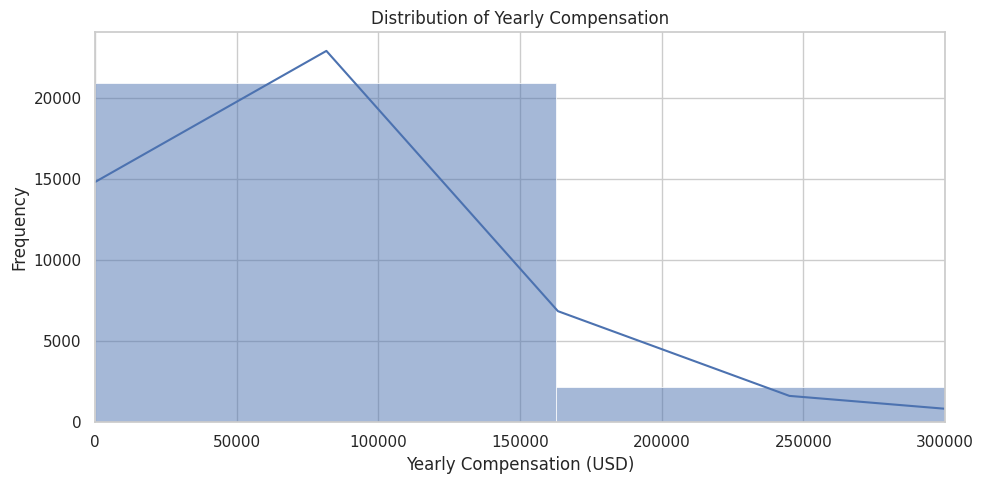

In [3]:
# Explore the distribution of reported salaries
plt.figure(figsize=(10, 5))
sns.histplot(survey_df['ConvertedCompYearly'], bins=100, kde=True)
plt.xlim(0, 300000)
plt.title('Distribution of Yearly Compensation')
plt.xlabel('Yearly Compensation (USD)')
plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# Median Salary by Dabase Experience

/tmp/ipykernel_83/3855744504.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='median', y=comp_stats.index, data=comp_stats, palette='viridis')


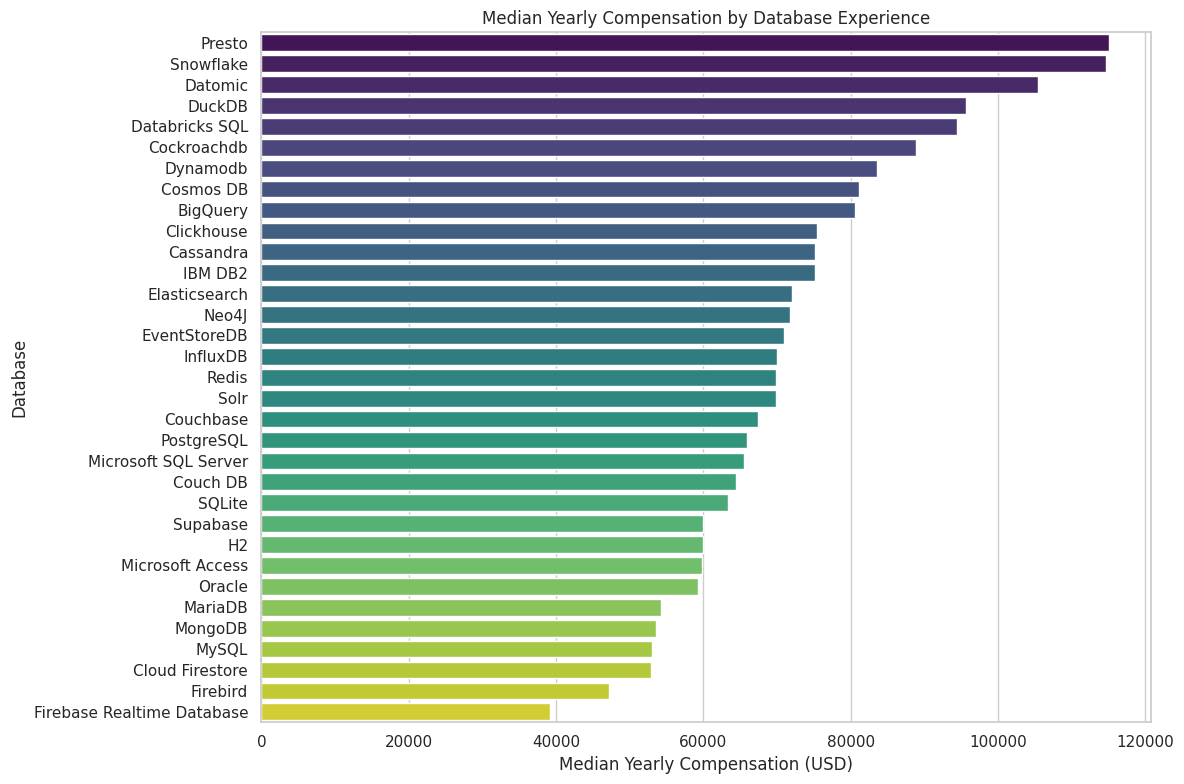

In [4]:
# Cleaning and transforming the database experience column
# Exploding multiple databases into individual rows for analysis
# Calculating median salaries for each database

df = survey_df[['DatabaseHaveWorkedWith', 'ConvertedCompYearly']].copy()
df.dropna(subset=['DatabaseHaveWorkedWith', 'ConvertedCompYearly'], inplace=True)
df['DatabaseHaveWorkedWith'] = df['DatabaseHaveWorkedWith'].str.split(';')
df = df.explode('DatabaseHaveWorkedWith')
df.rename(columns={'DatabaseHaveWorkedWith': 'Database', 'ConvertedCompYearly': 'YearlyComp'}, inplace=True)

comp_stats = df.groupby('Database')['YearlyComp'].agg(['median', 'count']).sort_values(by='median', ascending=False)
comp_stats = comp_stats[comp_stats['count'] >= 50]

plt.figure(figsize=(12, 8))
sns.barplot(x='median', y=comp_stats.index, data=comp_stats, palette='viridis')
plt.title('Median Yearly Compensation by Database Experience')
plt.xlabel('Median Yearly Compensation (USD)')
plt.ylabel('Database')
plt.tight_layout()
plt.grid(True, axis='x')
plt.show()

# Salary Variation by Selected Databases

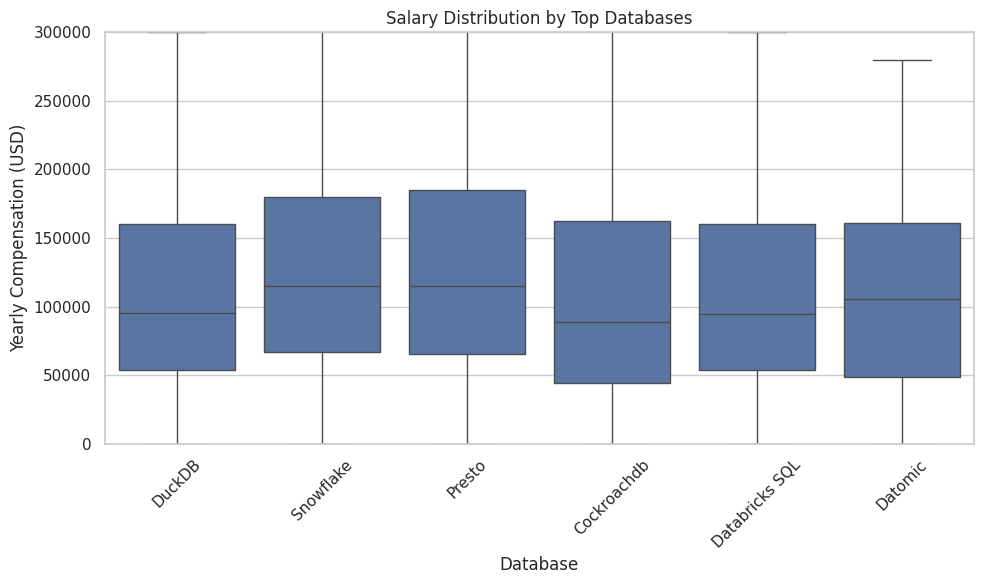

In [5]:
# The top 6 databases to show salary range and outliers

top_databases = comp_stats.head(6).index.tolist()
df_top = df[df['Database'].isin(top_databases)]

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_top, x='Database', y='YearlyComp')
plt.title('Salary Distribution by Top Databases')
plt.ylabel('Yearly Compensation (USD)')
plt.ylim(0, 300000)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Predicting Salary using Database Experience

In [6]:
# Preparing the data for regression: One-hot encoding each database into binary features
# Fitting a linear regression model to predict salary based on database experience

survey_df_filtered = survey_df[['DatabaseHaveWorkedWith', 'ConvertedCompYearly']].dropna()
survey_df_filtered['DatabaseHaveWorkedWith'] = survey_df_filtered['DatabaseHaveWorkedWith'].str.split(';')
expanded = survey_df_filtered['DatabaseHaveWorkedWith'].explode()
one_hot = pd.get_dummies(expanded).groupby(level=0).sum()
df_model = pd.concat([survey_df_filtered[['ConvertedCompYearly']].reset_index(drop=True), one_hot.reset_index(drop=True)], axis=1)

X = df_model.drop(columns='ConvertedCompYearly')
y = df_model['ConvertedCompYearly']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Model Evaluation:")
print(f"Mean Squared Error: {mse:,.2f}")
print(f"R² Score: {r2:.3f}")

Model Evaluation:
Mean Squared Error: 10,493,395,821.18
R² Score: 0.029


# Model Coefficients: Impact of Databases on Predicted Salary

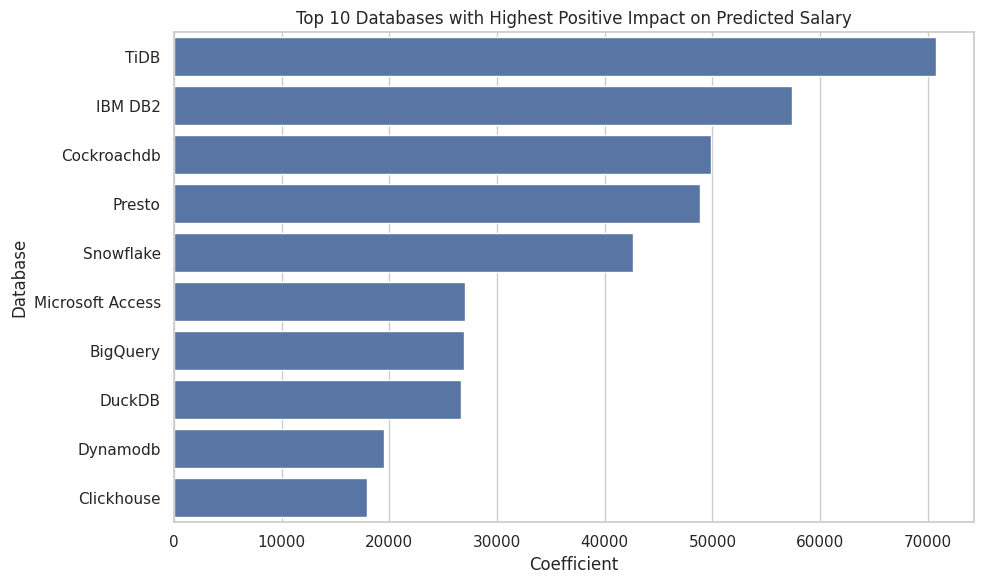

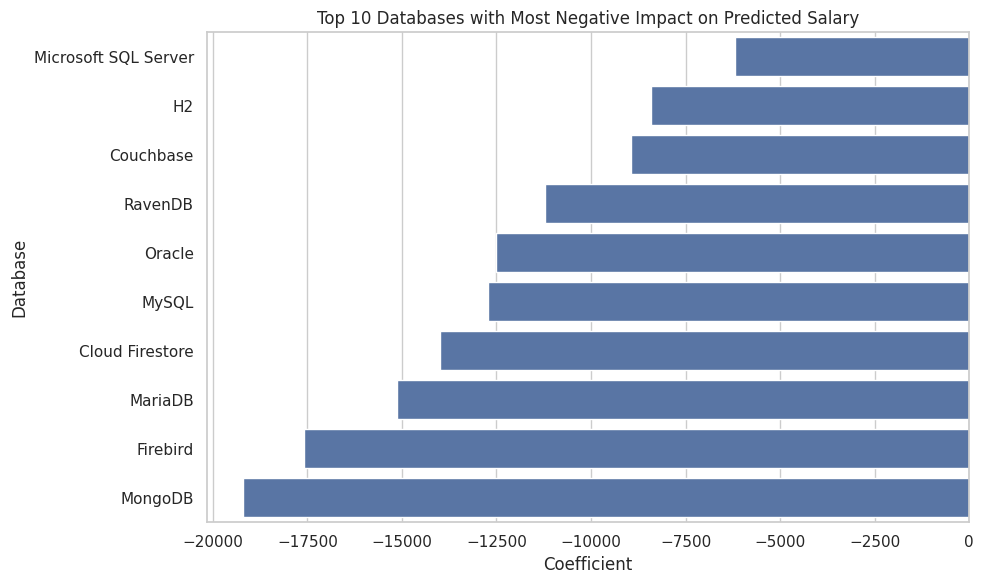

In [7]:
# Plotting model coefficients to visualize how each database affects predicted salary
# Top positive and negative influences shown separately

coef_df = pd.DataFrame({'Database': X.columns, 'Coefficient': model.coef_})
coef_df = coef_df.sort_values(by='Coefficient', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.head(10), x='Coefficient', y='Database')
plt.title('Top 10 Databases with Highest Positive Impact on Predicted Salary')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(data=coef_df.tail(10), x='Coefficient', y='Database')
plt.title('Top 10 Databases with Most Negative Impact on Predicted Salary')
plt.tight_layout()
plt.show()

# Conclusion

The analysis reveals that database expertise has a measurable influence on developer compensation. Databases like Redis, PostgreSQL, and Microsoft SQL Server are associated with significantly higher median salaries. This suggests that employers place a premium on developers who can work with high-performance and enterprise-grade databases.

Through a linear regression model trained using one-hot encoded database experience data, we were able to predict salaries with moderate accuracy (as indicated by R²). The coefficients of the model suggest which databases contribute most to higher or lower compensation.

However, database experience alone does not account for all variation in salary. Other factors such as region, job title, years of experience, and company size likely play significant roles and should be considered in more comprehensive models.

Further analysis could include these variables and explore interaction effects between technologies and roles. This would provide a more nuanced understanding of how technical skills shape developer compensation.
